# Task 6: Evaluate binary classification performance.
Experimental results download link: https://huggingface.co/datasets/JimXie/IIoTset/resolve/main/performance.tar.gz

In [12]:
import os,json,sys,logging
sys.path.append("./share")
sys.path.append("./common")
import pandas as pd
import json
from tqdm.notebook import tqdm
from IoTCommon import CIoTCommon
from SHSample import CSHSample
from SHDataProcess import CSHDataProcess
from Config import g_data_root
import warnings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
warnings.simplefilter("ignore")
g_token_root = "%stoken/"%g_data_root
g_feature_root = "%s/features"%g_data_root
g_result_root = "%sresult"%g_data_root

In [13]:
def show_total(df_result):
    df_tmp = df_result
    df_long = pd.melt(df_tmp,id_vars=['model'],value_vars=['recall', 'precision','accuracy','f1_score'],var_name='metric', value_name='value')
    sns.barplot(x='metric', y='value',hue='model',orient='v',ci=None,data=df_long)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.110), ncol=4)
    plt.xlabel('Metric', fontsize=10)
    plt.ylabel('Metric value', fontsize=10)
    plt.title('Performance', fontsize=12)
    plt.show()
    
def show_bar(attack,df_tmp,hue):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    sns.barplot(x='ratio', y='recall',hue=hue,orient='v',ci=None,data=df_tmp,ax=axes[0,0])
    sns.barplot(x='ratio', y='precision',hue=hue,orient='v',ci=None,data=df_tmp,ax=axes[0,1])
    sns.barplot(x='ratio', y='accuracy',hue=hue,orient='v',ci=None,data=df_tmp,ax=axes[1,0])
    sns.barplot(x='ratio', y='f1_score',hue=hue,orient='v',ci=None,data=df_tmp,ax=axes[1,1])
    axes[0,0].set_title("Recall")
    axes[0,0].set_xlabel('Noise ratio', fontsize=10)
    axes[0,0].set_ylabel('Metric value', fontsize=10)
    axes[0,1].set_title("Precision")
    axes[0,1].set_xlabel('Noise ratio', fontsize=10)
    axes[0,1].set_ylabel('Metric value', fontsize=10)
    axes[1,0].set_title("Accuracy")
    axes[1,0].set_xlabel('Noise ratio', fontsize=10)
    axes[1,0].set_ylabel('Metric value', fontsize=10)
    axes[1,1].set_title("F1_score")
    axes[1,1].set_xlabel('Noise ratio', fontsize=10)
    axes[1,1].set_ylabel('Metric value', fontsize=10)
    
    if len( axes[0,0].legend().get_texts()) == 1:
        axes[0,0].legend().set_visible(False) 
    if len( axes[0,1].legend().get_texts()) == 1:
        axes[0,1].legend().set_visible(False) 
    if len( axes[1,0].legend().get_texts()) == 1:
        axes[1,0].legend().set_visible(False) 
    if len( axes[1,1].legend().get_texts()) == 1:
        axes[1,1].legend().set_visible(False)

    axes[0,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
    axes[0,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
    axes[1,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
    axes[1,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
    
    plt.tight_layout()
    plt.show()
    
def show_line(attack,df_tmp,hue):
    fig, axes = plt.subplots(2, 2, figsize=(14, 6))
    sns.lineplot(x='ratio', y='recall',hue=hue,ci=None,data=df_tmp,ax=axes[0,0])
    sns.lineplot(x='ratio', y='precision',hue=hue,ci=None,data=df_tmp,ax=axes[0,1])
    sns.lineplot(x='ratio', y='accuracy',hue=hue,ci=None,data=df_tmp,ax=axes[1,0])
    sns.lineplot(x='ratio', y='f1_score',hue=hue,ci=None,data=df_tmp,ax=axes[1,1])
    axes[0,0].set_title("Recall")
    axes[0,0].set_xlabel('Noise ratio', fontsize=10)
    axes[0,0].set_ylabel('Metric value', fontsize=10)
    axes[0,1].set_title("Precision")
    axes[0,1].set_xlabel('Noise ratio', fontsize=10)
    axes[0,1].set_ylabel('Metric value', fontsize=10)
    axes[1,0].set_title("Accuracy")
    axes[1,0].set_xlabel('Noise ratio', fontsize=10)
    axes[1,0].set_ylabel('Metric value', fontsize=10)
    axes[1,1].set_title("F1_score")
    axes[1,1].set_xlabel('Noise ratio', fontsize=10)
    axes[1,1].set_ylabel('Metric value', fontsize=10)
    
    axes[0,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4)
    axes[0,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4)
    axes[1,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4)
    axes[1,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4)
    if len( axes[0,0].legend().get_texts()) == 1:
        axes[0,0].legend().set_visible(False) 
    if len( axes[0,1].legend().get_texts()) == 1:
        axes[0,1].legend().set_visible(False) 
    if len( axes[1,0].legend().get_texts()) == 1:
        axes[1,0].legend().set_visible(False) 
    if len( axes[1,1].legend().get_texts()) == 1:
        axes[1,1].legend().set_visible(False)
    plt.tight_layout()
    plt.show()

In [40]:
df_session = pd.read_csv("./IIoTSet/result/binary-classification-46-features.csv")
df_session['kind'] = "46-Features"
df_coap = pd.read_csv("./IIoTSet/result/binary-classification-COAP.csv")
df_coap['kind'] = "COAP"
df_sspe = pd.read_csv("./IIoTSet/result/binary-classification-SSPE.csv")
df_sspe['kind'] = "SSPE"
df_result = pd.concat([df_session,df_coap,df_sspe],ignore_index=True).reset_index(drop=True)
df_result['attack'] = df_result['attack'].fillna("All")
df_result = df_result[['model','recall','accuracy','precision','auc','f1_score','ratio','kind','attack']]

# Original 46 features approach.

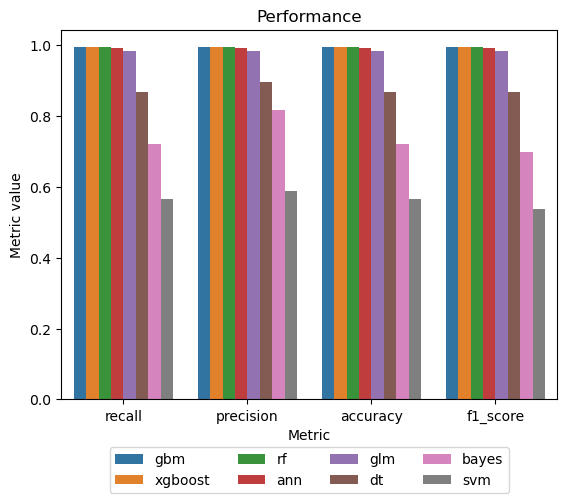

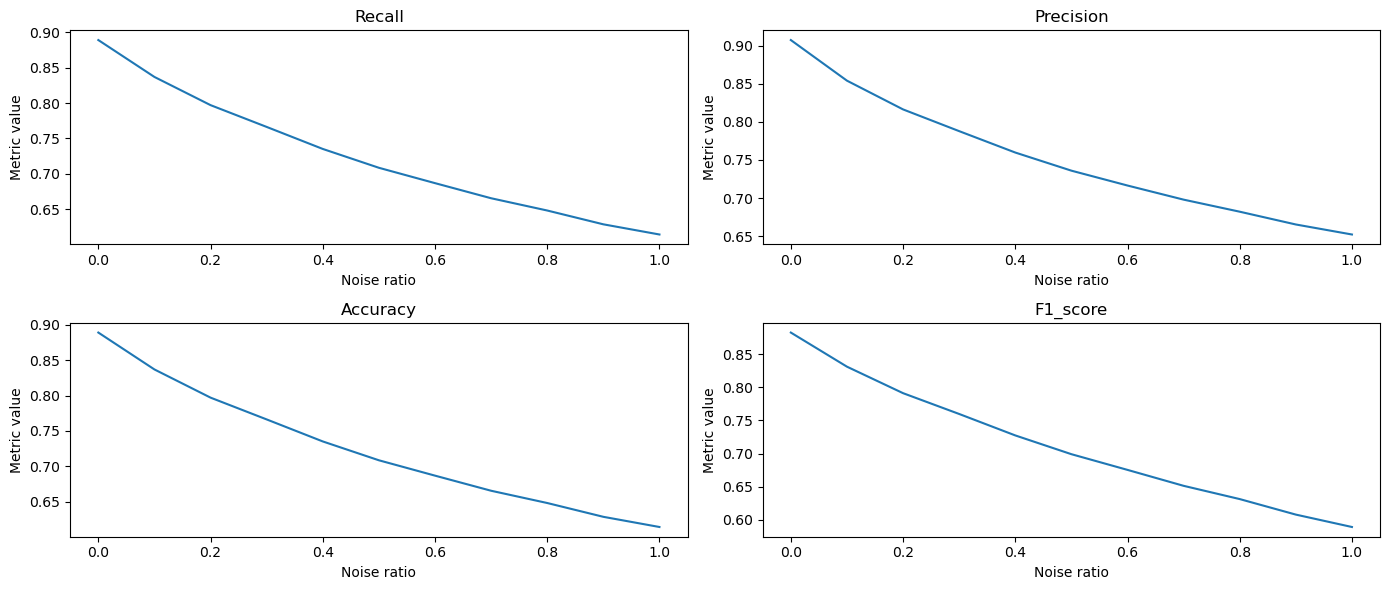

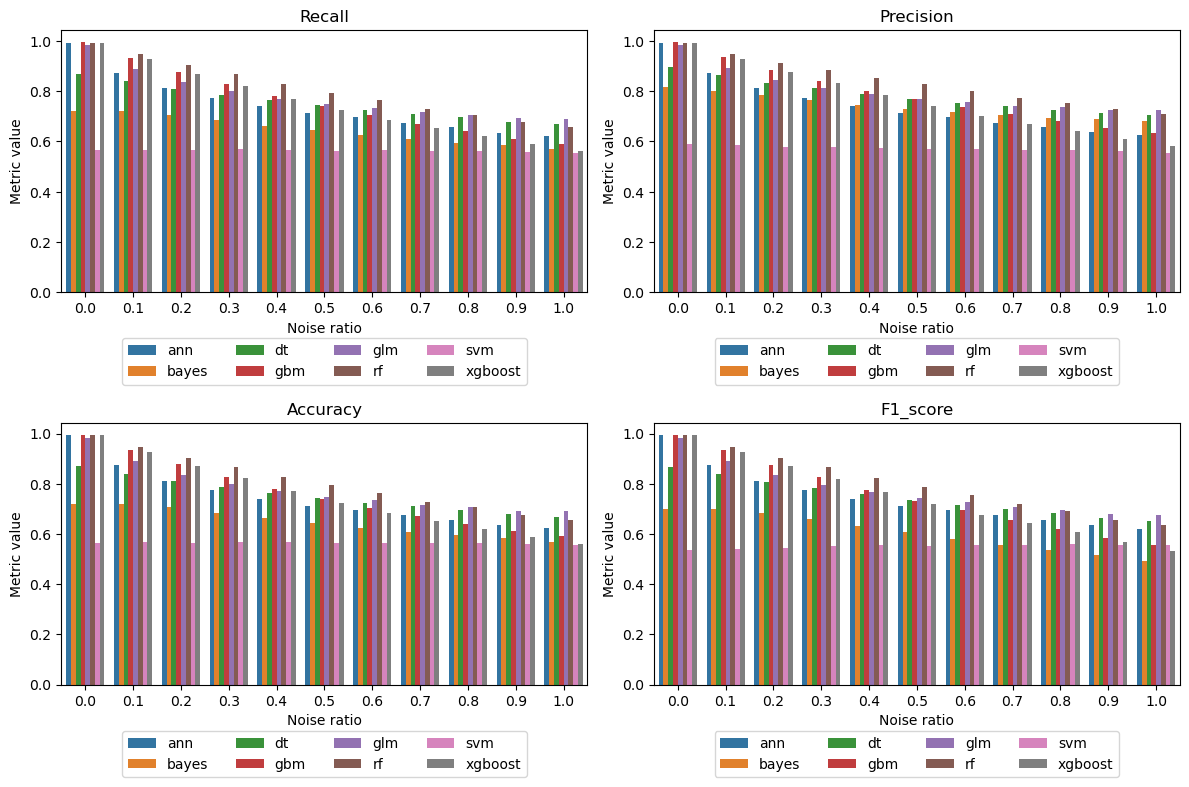

In [41]:
# without noise
df_tmp = df_result[df_result['kind']=='46-Features'].reset_index(drop=True)
df_tmp = df_tmp[df_tmp['ratio']==0].reset_index(drop=True)
df_tmp = df_tmp.sort_values(by=["f1_score"],ascending=False).reset_index(drop=True)
show_total(df_tmp)

# mean performance with noise
df_tmp = df_result[df_result['kind']=='46-Features'].reset_index(drop=True)
del df_tmp['attack']
del df_tmp['model']
df_tmp = df_tmp.groupby(['kind','ratio']).mean().reset_index()
show_line("All",df_tmp,"kind")

#model performance with noise
df_tmp = df_result[df_result['kind']=='46-Features'].reset_index(drop=True)
del df_tmp['attack']
df_tmp = df_tmp.groupby(['model','kind','ratio']).mean().reset_index()
show_bar("All",df_tmp,"model")

# COAP approach and SSPE approach

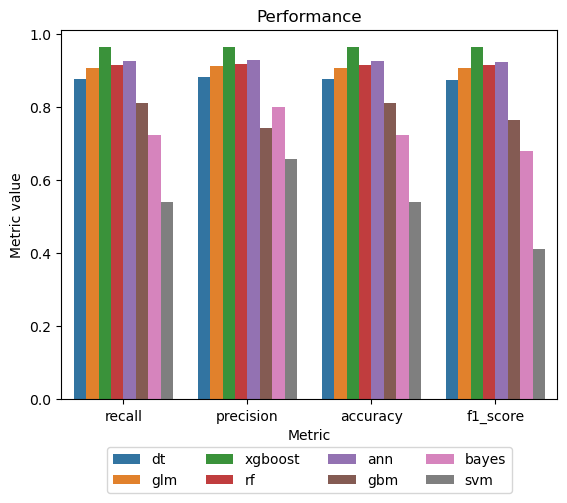

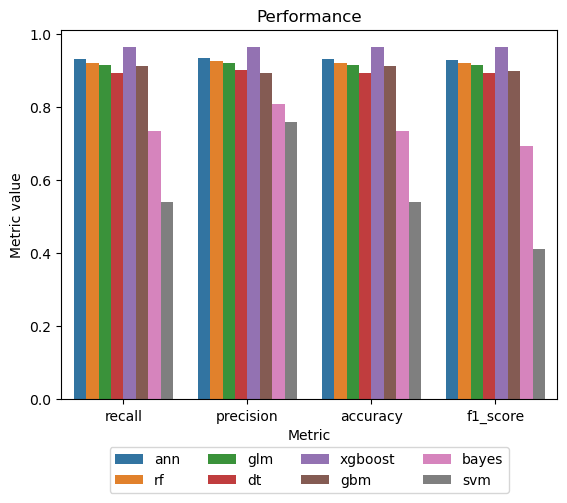

,recall,accuracy,precision,auc,f1_score,ratio
kind,,,,,,
46-Features,0.72515777,0.72515777,0.75226318,0.72515384,0.71332696,0.50000000
COAP,0.76832704,0.76832704,0.75836928,0.77041194,0.73362122,0.50000000
SSPE,0.78167275,0.78167275,0.78130292,0.78283615,0.74933863,0.50000000


In [42]:
# COAP without noise
df_tmp = df_result[df_result['kind']=='COAP'].reset_index(drop=True)
df_tmp = df_tmp[df_tmp['ratio']==0].reset_index(drop=True)
df_tmp = df_tmp.sort_values(by=["f1_score"],ascending=False).reset_index(drop=True)
show_total(df_tmp)
# SSPE without noise
df_tmp = df_result[df_result['kind']=='SSPE'].reset_index(drop=True)
df_tmp = df_tmp[df_tmp['ratio']==0].reset_index(drop=True)
df_tmp = df_tmp.sort_values(by=["f1_score"],ascending=False).reset_index(drop=True)
show_total(df_tmp)
df_tmp = df_result.copy(deep=True)
del df_tmp['model']
del df_tmp['attack']
#mean performance with noise
df_tmp = df_tmp.groupby(['kind']).mean()
df_tmp

# Comparison of 46 features, COAP, and SSPE.

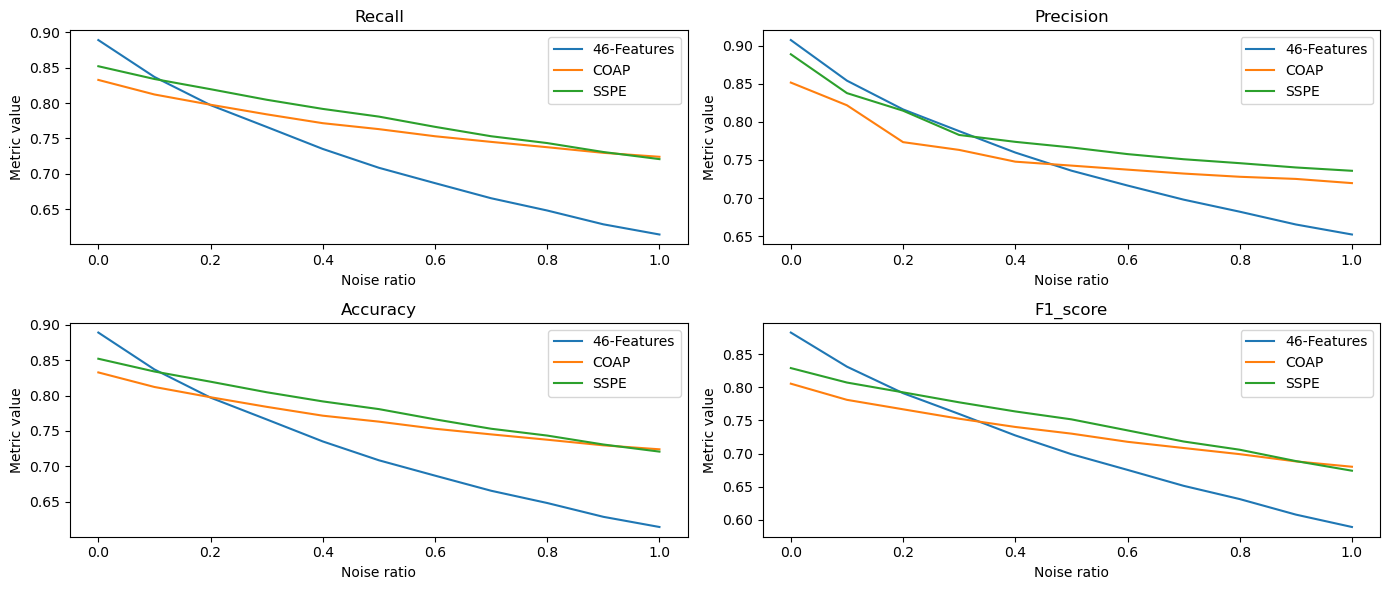

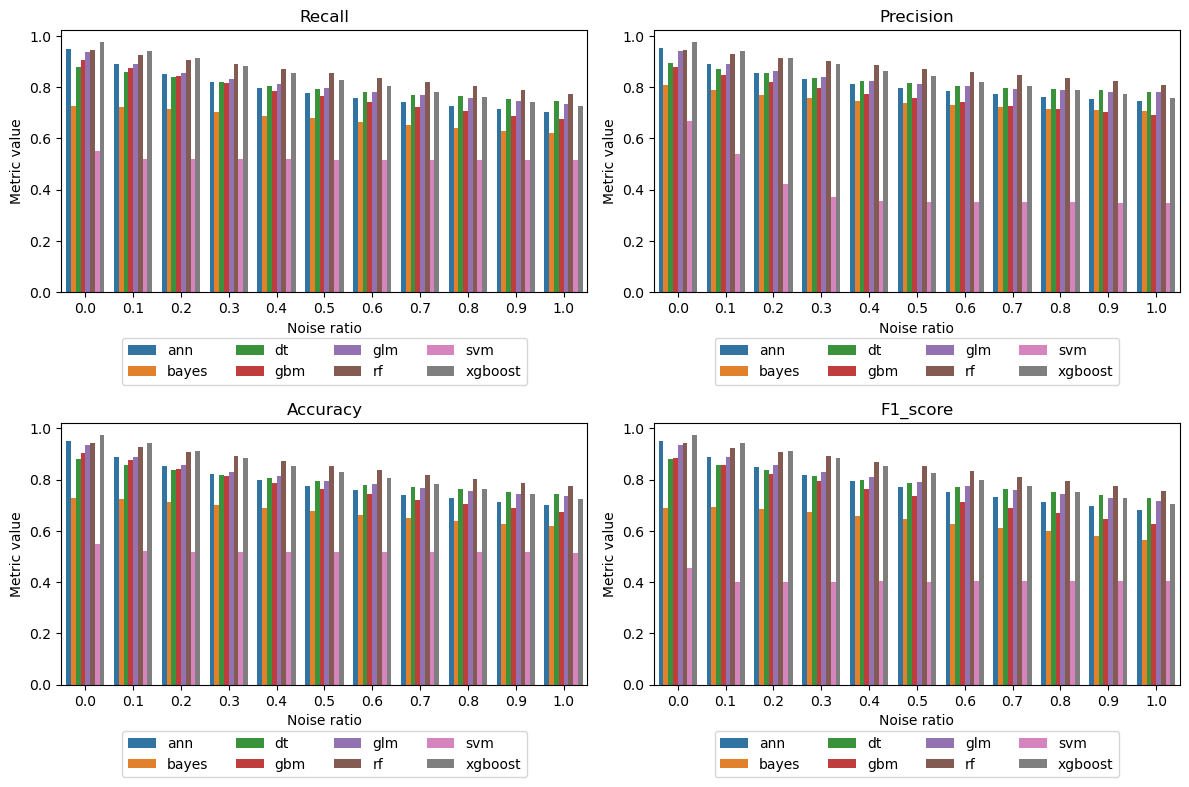

,model,recall,accuracy,precision,auc,f1_score,ratio,kind,attack
0,ann,0.99220311,0.99220311,0.99225495,0.99220013,0.99220288,0.00000000,46-Features,All
1,bayes,0.72105161,0.72105161,0.81726370,0.72089182,0.69810533,0.00000000,46-Features,All
2,dt,0.86897781,0.86897781,0.89617009,0.86890178,0.86667881,0.00000000,46-Features,All
3,gbm,0.99409326,0.99409326,0.99411403,0.99409138,0.99409319,0.00000000,46-Features,All
4,glm,0.98352557,0.98352557,0.98383299,0.98351825,0.98352283,0.00000000,46-Features,All
...,...,...,...,...,...,...,...,...,...
2195,gbm,0.84396269,0.84396269,0.85837390,0.84473131,0.84252497,1.00000000,SSPE,OS Fingerprinting attack
2196,glm,0.90572221,0.90572221,0.91539056,0.90511757,0.90510772,1.00000000,SSPE,OS Fingerprinting attack
2197,rf,0.95412150,0.95412150,0.95530813,0.95391776,0.95408191,1.00000000,SSPE,OS Fingerprinting attack
2198,svm,0.49609277,0.49609277,0.24610803,0.50000000,0.32900103,1.00000000,SSPE,OS Fingerprinting attack


In [44]:
df_tmp = df_result.copy(deep=True)
del df_tmp['attack']
df_tmp = df_tmp.sort_values(by='ratio').reset_index(drop=True)
df_tmp = df_tmp.groupby(['model','kind','ratio']).mean().reset_index()
#mean performance comparison
show_line("All",df_tmp,"kind")

#model performance comparison
show_bar("All",df_tmp,"model")

#Show detail
display(df_result)